In [ ]:
import os
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import evalml
import warnings
warnings.filterwarnings("ignore")

In [60]:
emotions={
  'Confident':'Confident',
  'Neutral':'Neutral',
  'Nervous':'Non Confident',
}
observed_emotions=['Confident', 'Neutral', 'Non Confident']

# EVAL ML

In [61]:
#- - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result
z1 = []
z2 = []
def load_data():
    x,y=[],[]
    for file in glob.glob("Final Dataset\\Padded Audio\\*\\*.wav"):
        file_name=os.path.basename(file)
        x1 = file_name
        x1 = x1.split("_")
        x1 = x1[2].split(".wav")
        emotion=emotions[x1[0]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=False, mel=True)
        x.append(feature)
        y.append(emotion)
        z1.append(x)
        z2.append(y)
    return evalml.preprocessing.split_data(np.array(x), y,problem_type='multiclass', test_size=.2)

In [62]:
x_train,x_test,y_train,y_test=load_data()

In [63]:
from evalml.problem_types import detect_problem_type
detect_problem_type(y_train)

<ProblemTypes.MULTICLASS: 'multiclass'>

In [64]:
from evalml.automl import AutoMLSearch
automl = AutoMLSearch(X_train=x_train, y_train=y_train, problem_type='multiclass')
automl.search()

	High coefficient of variation (cv >= 0.5) within cross validation scores.
	Elastic Net Classifier w/ Label Encoder + Imputer + Standard Scaler may not perform as estimated on unseen data.
	High coefficient of variation (cv >= 0.5) within cross validation scores.
	Logistic Regression Classifier w/ Label Encoder + Imputer + Standard Scaler may not perform as estimated on unseen data.
	High coefficient of variation (cv >= 0.5) within cross validation scores.
	LightGBM Classifier w/ Label Encoder + Imputer may not perform as estimated on unseen data.
	High coefficient of variation (cv >= 0.5) within cross validation scores.
	Decision Tree Classifier w/ Label Encoder + Imputer may not perform as estimated on unseen data.


In [65]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,6,Random Forest Classifier w/ Label Encoder + Im...,6,0.807349,0.099221,0.807349,96.527122,False,"{'Label Encoder': {'positive_label': None}, 'I..."
1,8,Extra Trees Classifier w/ Label Encoder + Imputer,8,0.823008,0.065438,0.823008,96.459761,False,"{'Label Encoder': {'positive_label': None}, 'I..."
2,3,XGBoost Classifier w/ Label Encoder + Imputer,3,0.979822,0.181474,0.979822,95.785216,False,"{'Label Encoder': {'positive_label': None}, 'I..."
3,5,CatBoost Classifier w/ Label Encoder + Imputer,5,1.044681,0.008067,1.044681,95.506218,False,"{'Label Encoder': {'positive_label': None}, 'I..."
4,4,LightGBM Classifier w/ Label Encoder + Imputer,4,1.144511,0.290322,1.144511,95.076789,True,"{'Label Encoder': {'positive_label': None}, 'I..."
5,1,Elastic Net Classifier w/ Label Encoder + Impu...,1,1.164692,0.526173,1.164692,94.989978,True,"{'Label Encoder': {'positive_label': None}, 'I..."
6,2,Logistic Regression Classifier w/ Label Encode...,2,1.622027,0.741787,1.622027,93.022717,True,"{'Label Encoder': {'positive_label': None}, 'I..."
7,7,Decision Tree Classifier w/ Label Encoder + Im...,7,7.328084,2.009545,7.328084,68.477633,True,"{'Label Encoder': {'positive_label': None}, 'I..."
8,0,Mode Baseline Multiclass Classification Pipeline,0,23.247253,0.000000,23.247253,0.000000,False,"{'Label Encoder': {'positive_label': None}, 'B..."


In [66]:
best_pipeline=automl.best_pipeline
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


*******************************************************
* Random Forest Classifier w/ Label Encoder + Imputer *
*******************************************************

Problem Type: multiclass
Model Family: Random Forest

Pipeline Steps
1. Label Encoder
	 * positive_label : None
2. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
3. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for multiclass problems.
Total training time (including CV): 4.8 seconds

Cross Validation
----------------
             Log Loss Multiclass  MCC Multiclass  AUC Weighted  AUC Macro  AUC Micro  Precision Weighted  Precision Macro  Precision Micro  F1 Weighted  F1 Macro  F1 Micro  Balanced Accuracy Multiclass  Accuracy Multiclass # Training # Validation
0                          0.759           0.470         0.812      0.813      0.837               0.

In [67]:
best_pipeline = automl.best_pipeline
print(best_pipeline.name)
print(best_pipeline.parameters)
best_pipeline.predict(x_train)

Random Forest Classifier w/ Label Encoder + Imputer
{'Label Encoder': {'positive_label': None}, 'Imputer': {'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Random Forest Classifier': {'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}


93         Confident
298          Neutral
10         Confident
244    Non Confident
32         Confident
           ...      
302          Neutral
353          Neutral
86         Confident
275          Neutral
339          Neutral
Length: 312, dtype: category
Categories (3, object): ['Confident', 'Neutral', 'Non Confident']

In [68]:
predicted = best_pipeline.predict(x_train)
import pandas as pd
predicted = pd.Series(predicted).array
print(predicted)
print(len(y_train))

['Confident', 'Neutral', 'Confident', 'Non Confident', 'Confident', ..., 'Neutral', 'Neutral', 'Confident', 'Neutral', 'Neutral']
Length: 312
Categories (3, object): ['Confident', 'Neutral', 'Non Confident']
312


In [69]:
y_train_arr = pd.Series(y_train).array
count = 0
for i in range(len(predicted)):
    if predicted[i] == y_train_arr[i]:
        count = count+1
print(count)
print("accuracy: ",count*100/len(predicted))

303
accuracy:  97.11538461538461


Train Data

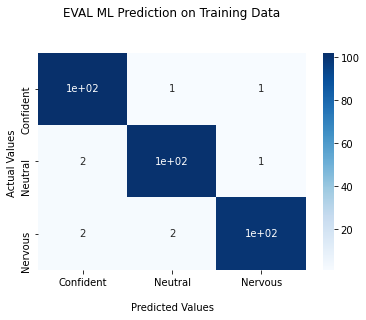

Classification Report:
               precision    recall  f1-score   support

    Confident       0.96      0.98      0.97       104
      Neutral       0.97      0.97      0.97       104
Non Confident       0.98      0.96      0.97       104

     accuracy                           0.97       312
    macro avg       0.97      0.97      0.97       312
 weighted avg       0.97      0.97      0.97       312



In [75]:
y_pred=best_pipeline.predict(x_train)
import matplotlib.pyplot as plt
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_train, y_pred)
import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('EVAL ML Prediction on Training Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Confident', 'Neutral', 'Nervous'])
ax.yaxis.set_ticklabels(['Confident', 'Neutral', 'Nervous'])

## Display the visualization of the Confusion Matrix.
plt.show()

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_train, y_pred))

Test Data

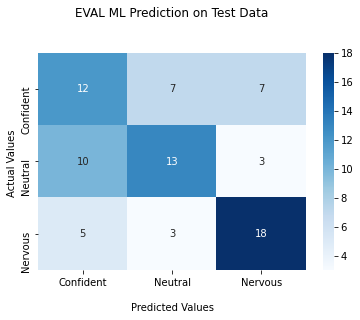

Classification Report:
               precision    recall  f1-score   support

    Confident       0.44      0.46      0.45        26
      Neutral       0.57      0.50      0.53        26
Non Confident       0.64      0.69      0.67        26

     accuracy                           0.55        78
    macro avg       0.55      0.55      0.55        78
 weighted avg       0.55      0.55      0.55        78



In [74]:
y_pred=best_pipeline.predict(x_test)
import matplotlib.pyplot as plt
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('EVAL ML Prediction on Test Data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Confident', 'Neutral', 'Nervous'])
ax.yaxis.set_ticklabels(['Confident', 'Neutral', 'Nervous'])

## Display the visualization of the Confusion Matrix.
plt.show()

from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))

In [16]:
trained_pipelines = automl.train_pipelines([automl.get_pipeline(i) for i in [0, 1, 2]])
trained_pipelines

{'Mode Baseline Multiclass Classification Pipeline': pipeline = MulticlassClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Baseline Classifier': ['Baseline Classifier', 'Label Encoder.x', 'Label Encoder.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Baseline Classifier':{'strategy': 'mode'}}, custom_name='Mode Baseline Multiclass Classification Pipeline', random_seed=0),
 'Elastic Net Classifier w/ Label Encoder + Imputer + Standard Scaler': pipeline = MulticlassClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Imputer': ['Imputer', 'X', 'Label Encoder.y'], 'Standard Scaler': ['Standard Scaler', 'Imputer.x', 'Label Encoder.y'], 'Elastic Net Classifier': ['Elastic Net Classifier', 'Standard Scaler.x', 'Label Encoder.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 

# Flaml

In [23]:
from flaml import AutoML

# Initialize an AutoML instance
time_define = [5,10,20,30,40,50,60]
accuracy_count = []
automl = AutoML()
# Specify automl goal and constraint
for i in range(len(time_define)):
    automl_settings = {
        "time_budget": time_define[i],  # in seconds
        "metric": 'accuracy',
        "task": 'classification'}
    automl.fit(X_train=x_train, y_train=y_train,**automl_settings)
    y_pred = automl.predict(x_test)
    accuracy_count.append(accuracy_score(y_test,y_pred))

[flaml.automl: 03-20 19:46:45] {2068} INFO - task = classification
[flaml.automl: 03-20 19:46:45] {2070} INFO - Data split method: stratified
[flaml.automl: 03-20 19:46:45] {2074} INFO - Evaluation method: holdout
[flaml.automl: 03-20 19:46:45] {2155} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 03-20 19:46:45] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-20 19:46:45] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-20 19:46:45] {2616} INFO - Estimated sufficient time budget=156s. Estimated necessary time budget=4s.
[flaml.automl: 03-20 19:46:45] {2663} INFO -  at 0.1s,	estimator lgbm's best error=0.5294,	best estimator lgbm's best error=0.5294
[flaml.automl: 03-20 19:46:45] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-20 19:46:45] {2663} INFO -  at 0.1s,	estimator lgbm's best error=0.4706,	best estimator lgbm's best error=0.4706
[flaml.

In [31]:
data = pd.DataFrame({ "Time": [str(x)+" sec" for x in time_define], "Accuracy": [str(round(x*100,2))+"%" for x in accuracy_count] })
data

,Time,Accuracy
0,5 sec,51.28%
1,10 sec,61.54%
2,20 sec,53.85%
3,30 sec,55.13%
4,40 sec,55.13%
5,50 sec,55.13%
6,60 sec,55.13%
